In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:

os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/input"

In [4]:
!kaggle datasets download -d devbatrax/fracture-detection-using-x-ray-images

Dataset URL: https://www.kaggle.com/datasets/devbatrax/fracture-detection-using-x-ray-images
License(s): Apache 2.0
100% 172M/172M [00:08<00:00, 28.1MB/s]
100% 172M/172M [00:08<00:00, 20.5MB/s]


In [5]:
!unzip \*.zip  && rm *.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: data/train/fractured/99-rotated2-rotated3-rotated3.jpg  
  inflating: data/train/fractured/99-rotated2-rotated3.jpg  
  inflating: data/train/fractured/99-rotated2.jpg  
  inflating: data/train/fractured/99-rotated3-rotated1-rotated1.jpg  
  inflating: data/train/fractured/99-rotated3-rotated1-rotated2.jpg  
  inflating: data/train/fractured/99-rotated3-rotated1-rotated3.jpg  
  inflating: data/train/fractured/99-rotated3-rotated1.jpg  
  inflating: data/train/fractured/99-rotated3-rotated2-rotated1.jpg  
  inflating: data/train/fractured/99-rotated3-rotated2-rotated2.jpg  
  inflating: data/train/fractured/99-rotated3-rotated2-rotated3.jpg  
  inflating: data/train/fractured/99-rotated3-rotated2.jpg  
  inflating: data/train/fractured/99-rotated3-rotated3-rotated1.jpg  
  inflating: data/train/fractured/99-rotated3-rotated3-rotated2.jpg  
  inflating: data/train/fractured/99-rotated3-rotated3-rotated3.jpg  
  inflating: data/

In [6]:
import os

# Ana veri dizini
base_dir = '/content/data/train'

# Sınıf dizinlerini listele
class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print("Classes found:", class_dirs)

Classes found: ['not fractured', 'fractured']


In [ ]:
import os

def count_png_files(base_dir):
    counts = {}
    total_count = 0
    # Sınıf dizinlerini listele
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Her sınıf dizinindeki .png dosyalarını say
    for class_dir in class_dirs:
        class_path = os.path.join(base_dir, class_dir)
        png_files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        count = len(png_files)
        counts[class_dir] = count
        total_count += count

    return counts, total_count

# Ana veri dizinleri
train_dir = '/content/datasets/open/dataset/train'
test_dir = '/content/datasets/open/dataset/train'

# Train dizinindeki .png dosyalarını say
train_counts, train_total = count_png_files(train_dir)
print("Train directory .png file counts:")
for class_dir, count in train_counts.items():
    print(f"Class '{class_dir}' contains {count} .png files.")
print(f"Total .png files in train directory: {train_total}")

# Test dizinindeki .png dosyalarını say
test_counts, test_total = count_png_files(test_dir)
print("\nTest directory .png file counts:")
for class_dir, count in test_counts.items():
    print(f"Class '{class_dir}' contains {count} .png files.")
print(f"Total .png files in test directory: {test_total}")

# Toplam dosya sayılarını en sonda göster
print(f"\nTotal .png files in train directory: {train_total}")
print(f"Total .png files in test directory: {test_total}")


In [19]:

#Verileri okutmak için path komutunu kullanıyoruz
train_dir = Path('/content/data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/data/val')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    #Veri setinde klasör adlarını kullanarak dataframemizi etiketliyoruz
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [20]:
# Etiketleme ve veri setini kontrol için basit veritabanı kodları kullanımı
print(f'Resim Sayısı: {train_df.shape[0]}\n')
print(f'Farklı Etiket Sayısı: {len(train_df.Label.unique())}\n')
print(f'Etiket İsimleri: {train_df.Label.unique()}')
train_df.head(5)

Resim Sayısı: 7269

Farklı Etiket Sayısı: 2

Etiket İsimleri: ['not fractured' 'fractured']


,Filepath,Label
0,/content/data/train/not fractured/17-rotated3-...,not fractured
1,/content/data/train/fractured/66-rotated1-rota...,fractured
2,/content/data/train/fractured/42-rotated3-rota...,fractured
3,/content/data/train/fractured/12-rotated2-rota...,fractured
4,/content/data/train/fractured/69-rotated2-rota...,fractured


In [21]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

Found 7269 validated image filenames belonging to 2 classes.
Found 1772 validated image filenames belonging to 2 classes.
Found 1772 validated image filenames belonging to 2 classes.


In [22]:
pretrained_model = tf.keras.applications.MobileNetV2(
input_shape=(224, 224, 3),
include_top=False,
weights='imagenet',
pooling='avg'
)
pretrained_model.trainable = False

In [26]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(65, activation='relu')(x)
x = tf.keras.layers.Dense(30, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True)])


Epoch 1/15
228/228 [==============================] - 26s 95ms/step - loss: 0.3312 - accuracy: 0.8477 - val_loss: 0.1321 - val_accuracy: 0.9498
Epoch 2/15
228/228 [==============================] - 21s 92ms/step - loss: 0.1083 - accuracy: 0.9561 - val_loss: 0.0748 - val_accuracy: 0.9712
Epoch 3/15
228/228 [==============================] - 19s 84ms/step - loss: 0.0485 - accuracy: 0.9821 - val_loss: 0.0330 - val_accuracy: 0.9848
Epoch 4/15
228/228 [==============================] - 21s 91ms/step - loss: 0.0522 - accuracy: 0.9805 - val_loss: 0.0694 - val_accuracy: 0.9735
Epoch 5/15
228/228 [==============================] - 22s 95ms/step - loss: 0.0268 - accuracy: 0.9897 - val_loss: 0.0638 - val_accuracy: 0.9740
Epoch 6/15
228/228 [==============================] - 22s 97ms/step - loss: 0.0178 - accuracy: 0.9930 - val_loss: 0.0227 - val_accuracy: 0.9921
Epoch 7/15
228/228 [==============================] - 20s 88ms/step - loss: 0.0119 - accuracy: 0.9956 - val_loss: 0.0298 - val_accuracy:

In [28]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Tahmin Doğruluk Oranı: {100*acc:.2f}%')

56/56 [==============================] - 7s 127ms/step
Tahmin Doğruluk Oranı: 99.49%


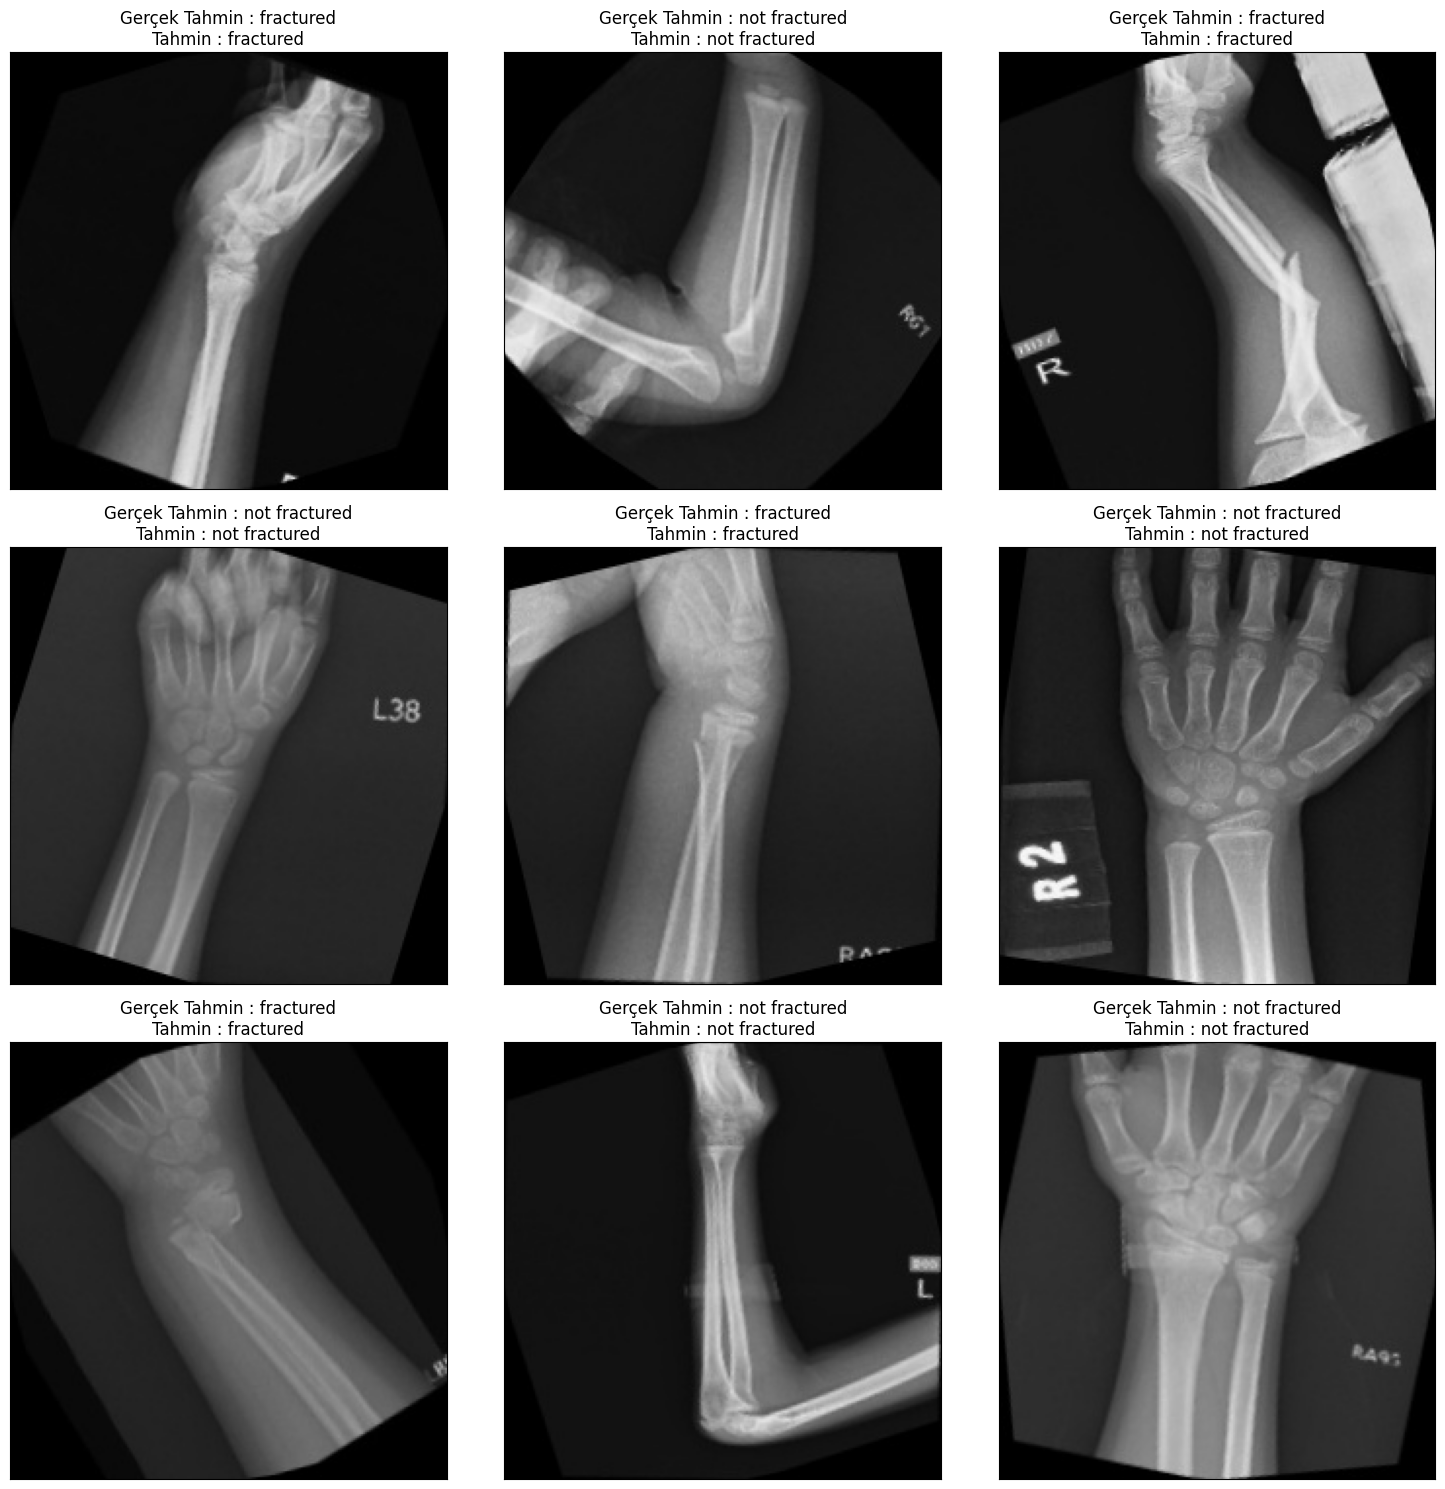

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Gerçek Tahmin : {test_df.Label.iloc[i]}\nTahmin : {pred[i]}")
plt.tight_layout()
plt.show()